## Ephemeris for Physical Observations of the Sun

U ovoj svesci ćemo implementirati algoritam iz dvadeset devetog poglavlja knjige "Astronomical Algorithms" Žana Mijusa, koji se bavi određivanjem efemerida za posmatranje pojava na Suncu. Formule koje ćemo koristiti je otkrio Ričard Karington, engleski astronom koji se bavio upravo posmatranjima Sunca. Između ostalog, otkrio je erupcije na površini Sunca i njegovu diferencijalnu rotaciju.

Glavni cilj algoritma je da, za dati trenutak u vremenu, izračuna sledeće vrednosti:

- **P**  - Pozicioni ugao između geocentričnog severnog pola Sunca i severnog kraja Sunčeve ose rotacije, mereno od geocentrične severne tačke diska ka istoku. Kreće se od -26°.3 do 26°.3.
- **B0** - Heliografska latituda centra Sunčevog diska. Ona nam predstavlja nagnutost Sunčevog severnog pola ka Zemlji, i kreće se od -7°.25 do +7°.25.
- **L0** - Heliografska longituda centra Sunčevog diska. L0 se smanjuje za ok 13°.2 dnevno, dok ne dođe do 0°. Trenutak kada L0 prođe kroz 0° se naziva početkom sinodičke rotacije Sunca.

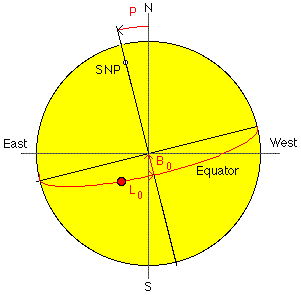



In [ ]:
import numpy as np
import ephem
import pandas as pd
import matplotlib.pyplot as plt
import astropy.time
from datetime import datetime, timezone
from tabulate import tabulate

Pre svega, potrebna nam je procedura koja konvertuje građanske datume u julijanske dane. Uz nju ide i procedura koja julijanske dane pretvara u julijanske efemeridske dane, kao i procedura koja nam za prosleđeni julijanski dan vraća odgovarajući julijanski vek. Ove formule se mahom nalaze u sedmoj i desetoj glavi knjige.

In [ ]:
# takes a datetime object
def utc2jd(date):
    y = date.year
    m = date.month
    d = date.day + (date.hour + (date.minute/60) + (date.second/3600)) / 24
    
    if m <= 2:
        y = y - 1
        m = m + 12
    
    a = y // 100
    b = 2 - a + a // 4
    
    jd = int(365.25*(y+4716)) + int(30.6001*(m+1)) + d + b - 1524.5
    
    return jd

U funckiji koja vrši konverziju julijanskog u julijanski efemeridski dan nam je potrebna informacija o razlici između terestrijalnog (TDT) i građanskog vremena (UTC) za dati julijanski dan. 

In [ ]:
# finds the td-ut for the date specified as the "now" datetime object
def jd2jde(jd, now):
    now = astropy.time.Time(now, format="datetime")
    t1 = astropy.time.Time(now, scale="tt")
    dt = int(t1.strftime("%s")) - int(now.strftime("%s"))
    
    return jd + dt/86400

In [ ]:
def jd2jc(jde):

    return (jde-2451545.0)/36525

Definisaćemo funkciju *get_tik(jde)*, koja za prosleđeni julijanski efemeridski dan vraća vrednosti Theta, I i K, gde I predstavlja nagib Sunčevog ekvatora u odnosu na ekliptiku, a K longitudu uzlaznog čvora Sunčevog ekvatora na ekliptici.

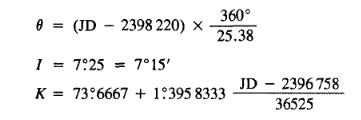

In [1]:
def get_tik(jde):
    theta = ((jde - 2398220) * (360) / 25.38) % 360
    i = 7.25
    k = (73.6667) + (1.3958333) * (jde - 2396758) / (36525) 
    
    return (theta, i, k)

Sada kada imamo ove vrednosti, biće nam potrebna i prividna longituda Sunca (sa i bez uračunate nutacije), kao i vrednost nagnutosti ekliptike. Za to definišemo narednih nekoliko funkcija.

Funkcija *get_nutation(jde)* je zasnovana na algoritmu iz glave 22, i omogućava nam da za prosleđeni julijanski efemeridski dan dobijemo korekcije usled dejstva nutacije, *dp* i *de*.

In [ ]:
def get_nutation(jde):
    T = jd2jc(jde)
    L = np.deg2rad(280.4665 + 36000.7698*T)
    Lp = np.deg2rad(218.3165 + 481267.8813*T)
    Om = np.deg2rad(125.04452 - 1934.136261*T + 0.0020708*T**2 + T**3/450000)
    
    dp = (-17.20/3600) * np.sin(Om) + (1.32/3600) * np.sin(2*L) - (0.23/3600) * np.sin(2*Lp) + (0.21/3600) * np.sin(2*Om)
    de = (9.20/3600) * np.cos(Om) + (0.57/3600) * np.cos(2*L) + (0.10/3600) * np.cos(2*Lp) - (0.09/3600) * np.cos(2*Om)
    
    return dp, de

Funkcija *get_ecliptic(jde)* je takođe zasnovana na algoritmu iz glave 22, i ona nam vraća nagib ekliptike za prosleđeni datum (bez obračunatog uticaja nutacije).

In [ ]:
def get_ecliptic(jde):
    T = jd2jc(jde)
    e0 = 23.439291111 - (46.8150/3600) * T - (0.00059/3600) * T**2 + (0.001813/3600) * T**3
    
    return e0

Funkcija get_lambda(jde) je zasnovana na algoritmu iz glave 25, i ona izračunava longitudu Sunca za dati julijanski efemeridski dan.

In [ ]:
# niska preciznost jer nije obračunat uticaj merkura
# dat formulom 32.2 sa koeficijentima iz apendiksa 3
def get_lambda(jde):
    T = jd2jc(jde)
    L = 280.46646 + 36000.76983 * T #  + 0.0003032 * T**2
    M = 357.52911 + 35999.05029 * T # + 0.0001537 * T**2
    C = (1.914602 - 0.004817 * T - 0.000014 * T**2) * np.sin(np.deg2rad(M)) + (0.019993 - 0.000101 * T) * np.sin(2*np.deg2rad(M)) + 0.000289 * np.sin(3*np.deg2rad(M))  
    lon = L+C-180
    
    return lon

Sada kada smo definisali sve pomoćne funkcije, definisaćemo i glavnu funkciju *get_PBL(time)*. Ova funkcija, za datum formata YYYY-mm-dd HH:MM:SS, izračunava već objašnjene vrednosti P, B0 i L0, po formulama koje je pronašao Karington:

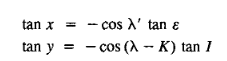
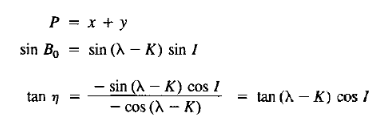
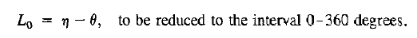

Ova funkcija radi tako što na propisan način poziva pomoćne funkcije i čuva međurezultate. 

Takođe definišemo i funkciju *get_PBL_list*, koja prima niz datuma, poziva *get_PBL* nad svakim, i rezultate predstavlja u formi grafika.

In [ ]:
# 2022-12-31 23:59:59
def get_PBL(time):
    now = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
    jd = utc2jd(now)
    jde = jd2jde(jd, now)

    theta, I, K = get_tik(jde)

    lon = get_lambda(jde) % 360

    dp, de = get_nutation(jde)
    eps = get_ecliptic(jde) + de
    r = ephem.Sun(now).earth_distance

    l = lon + 180 + (-20.4898/3600/r) 
    lp = l + dp

    x = np.rad2deg(np.arctan(-np.cos(np.deg2rad(lp)) * np.tan(np.deg2rad(eps))))
    y = np.rad2deg(np.arctan(-np.cos(np.deg2rad(l - K)) * np.tan(np.deg2rad(I))))

    P = x + y

    B = np.rad2deg(np.arcsin(np.sin(np.deg2rad(l - K)) * np.sin(np.deg2rad(I))))

    # tan zbog kvadranata, probati atan2
    g = -np.sin(np.deg2rad(l - K))*np.cos(np.deg2rad(I))
    d = -np.cos(np.deg2rad(l - K))
    tn = np.rad2deg(np.arctan(g/d))

    L = (tn - theta) % 360
    
    return P, B, L


def get_PBL_list(times):
    Ps = []
    Bs = []
    Ls = []
    for time in times:
        P, B, L = get_PBL(time)
        Ps.append(P)
        Bs.append(B)
        Ls.append(L)
        
    return Ps, Bs, Ls

Za kraj ćemo demonstrirati funkcionalnost koda kroz par praktičnih primera. Za 2006. godinu ćemo nacrtati grafike vrednosti P, B0 i L0 kroz vreme, kao i grafik zavisnosti vrednosti B0 od L0. Inspiracija za grafike je bio [sajt Jurgena Giesena](http://jgiesen.de/sunrot/index.html).

In [ ]:
dates = pd.date_range(start="2006/01/01 00:00:00", end="2006/12/31 00:00:00", freq="D")
dates = [str(x) for x in dates]

Ps, Bs, Ls = get_PBL_list(dates)

plt.plot(Bs, label="B0")
plt.plot(Ps, label="P")
plt.ylabel("[deg]")
plt.xticks(np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]),["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan"])
plt.title("B0 and P in 2006")
plt.legend()
plt.grid()
plt.show()

table = [["", "B0", "P"],
         ["Min", min(Bs), min(Ps)],
         ["Max", max(Bs), max(Ps)]]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid", stralign="center"))

plt.figure(figsize=(4, 8))
plt.plot(Ls, Bs)
plt.title("B0 vs L0 in 2006")
plt.xlabel("L0 [deg]")
plt.ylabel("B0 [deg]")
plt.grid()
plt.show()

plt.plot([x for x in range(len(Ls))], Ls)
plt.title("L0 in 2006")
plt.ylabel("L0 [deg]")
plt.xticks(np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]),["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan"])
plt.grid()
plt.show()